# MDAnalysis
The notebook is full centered on the MDAnlysis of a sample of water, in which the atom type 1 is the Hydrogen, while the atom type is the Oxygen. 

In [50]:
import ase
from ase import Atoms
from ase.io import read,write
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
import MDAnalysis.analysis.msd as msd
import maicos
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load the LAMMPS dump file and extract the first frame
# It will be used subsequently to create the topology in the MDAnalysis universe
starting_NPT_2_structure = read("/home/forina/Documents/MIT/MIT_Results/Trajectories/Water/SIMULATIONS/NPT_2/dump_NPT.lammpstrj", index="0",format = "lammps-dump-text")
starting_NPT_2_structure.write("/home/forina/Documents/MIT/MIT_Results/Trajectories/Water/SIMULATIONS/NPT_2/starting_configuration.xyz")


In [111]:
# Create the Universe
NPT_2_u = mda.Universe("/home/forina/Documents/MIT/MIT_Results/Trajectories/Water/SIMULATIONS/NPT_2/starting_configuration.xyz", "/home/forina/Documents/MIT/MIT_Results/Trajectories/Water/SIMULATIONS/NPT_2/dump_NPT.lammpstrj",  topology_format="XYZ", format="LAMMPSDUMP", atom_style="id type element x y z vx vy vz")

# If you want to use the trajectory file as a reference, you can uncomment the following lines
MIT_u = mda.Universe("/home/forina/Documents/MIT/MIT_Dataset/TRAJECTORY_RDF/TRAJECTORIES/Reference/starting_configuration.extxyz", "/home/forina/Documents/MIT/MIT_Dataset/TRAJECTORY_RDF/TRAJECTORIES/Reference/Reference_Trajectory.extxyz",  topology_format="XYZ", format="XYZ", atom_style="id type element x y z vx vy vz")


/home/forina/Documents/MIT/MIT_Results/mdaenv/lib/python3.12/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


In [112]:
# Store your universes in a dictionary
universes = {
    "NPT_2_u": NPT_2_u,
    "MIT": MIT_u
}

In [113]:
print(NPT_2_u.trajectory)

<DumpReader /home/forina/Documents/MIT/MIT_Results/Trajectories/Water/SIMULATIONS/NPT_2/dump_NPT.lammpstrj with 39628 frames of 327 atoms>


In [114]:
# Set the box dimensions for the refeerncence universe
# This is necessary for the RDF calculation
box = [22.87, 22.87, 22.87, 90.0, 90.0, 90.0]  # Lx, Ly, Lz, α, β, γ
for ts in MIT_u.trajectory:
 ts.dimensions = box

In [115]:
# Loop through each Universe and print statistics
for name, u in universes.items():
    print(f"\n=== Universe: {name} ===")
    print("Number of atoms in the Universe:", u.atoms.n_atoms)
    print("Number of frames in the Universe:", u.trajectory.n_frames)
    print(f"Trajectory: {u.trajectory}")
    print(f"Dimension of the system: {u.dimensions}")

    # Use the first structure as starting structure
    starting_structure = u.trajectory[0]

    # Estimate the density assuming a box of 15x15x15 Å³ if needed
    total_mass_grams = u.atoms.masses.sum() * 1.66054e-24  # atomic mass units to grams
    #volume_cm3 = 15 * 15 * 15 * 1.0e-24  # Å³ to cm³
    volume_cm3 = universes[name].trajectory[0].volume * 1.0e-24  # Å³ to cm³
    density = total_mass_grams / volume_cm3
    print(f"Starting Universe Density: {density:.4f} g/cm³")


=== Universe: NPT_2_u ===
Number of atoms in the Universe: 327
Number of frames in the Universe: 39628
Trajectory: <DumpReader /home/forina/Documents/MIT/MIT_Results/Trajectories/Water/SIMULATIONS/NPT_2/dump_NPT.lammpstrj with 39628 frames of 327 atoms>
Dimension of the system: [15.       15.       14.365929 90.       90.       90.      ]
Starting Universe Density: 1.0088 g/cm³

=== Universe: MIT ===
Number of atoms in the Universe: 1200
Number of frames in the Universe: 10001
Trajectory: <XYZReader /home/forina/Documents/MIT/MIT_Dataset/TRAJECTORY_RDF/TRAJECTORIES/Reference/Reference_Trajectory.extxyz with 10001 frames of 1200 atoms>
Dimension of the system: [22.87 22.87 22.87 90.   90.   90.  ]
Starting Universe Density: 1.0003 g/cm³


In [116]:
# Save also the revPBE0-D3 data for the comparison of the RDFs
# Here are also saved the reference data for the RDF
OO = pd.read_csv("/home/forina/Documents/MIT/MIT_Results/Trajectories/Water/Experimental_RDF/OO.csv", header=None, names=["r", "G(r)"])
OH = pd.read_csv("/home/forina/Documents/MIT/MIT_Results/Trajectories/Water/Experimental_RDF/OH.csv", header=None, names=["r", "G(r)"])
HH = pd.read_csv("/home/forina/Documents/MIT/MIT_Results/Trajectories/Water/Experimental_RDF/HH.csv", header=None, names=["r", "G(r)"])

In [117]:
# Dictionaries to store selections
hydrogens = {}
oxygens = {}

# Loop over all universes
for name, u in universes.items():
    print(f"\n=== Atom Selection in Universe: {name} ===")

    # Create selections
    hydrogen = u.select_atoms("element H", updating=True)
    oxygen = u.select_atoms("element O", updating=True)

    # Store in dictionaries with descriptive keys
    hydrogens[name] = hydrogen
    oxygens[name] = oxygen

    print(f"The total number of H atoms is {len(hydrogen)}")
    print(f"The total number of O atoms is {len(oxygen)}")


=== Atom Selection in Universe: NPT_2_u ===
The total number of H atoms is 218
The total number of O atoms is 109

=== Atom Selection in Universe: MIT ===
The total number of H atoms is 800
The total number of O atoms is 400


In [118]:
start_frames = {
    "NPT_2_u": 37500,
    "MIT": 9000
}


rdf_results = {}

for name, u in universes.items():
    print(f"\n=== Calculating RDFs for Universe: {name} ===")

    O = oxygens[name]
    H = hydrogens[name]
    r_max = u.dimensions[:3].min() / 2

    # Create RDF calculators
    rdf_OO = InterRDF(O, O, nbins=200, range=(0, r_max))
    rdf_HH = InterRDF(H, H, nbins=200, range=(0, r_max))
    rdf_OH = InterRDF(O, H, nbins=200, range=(0, r_max))

    # Run with the specific starting frame for this universe
    start = start_frames.get(name, 0)  # default to 0 if not specified
    print(f"Starting RDF from frame {start}")
    rdf_OO.run(start=start, verbose=True)
    rdf_HH.run(start=start, verbose=True)
    rdf_OH.run(start=start, verbose=True)

    rdf_results[name] = {
        "OO": rdf_OO,
        "HH": rdf_HH,
        "OH": rdf_OH
    }




=== Calculating RDFs for Universe: NPT_2_u ===
Starting RDF from frame 37500


  0%|          | 0/2128 [00:00<?, ?it/s]/home/forina/Documents/MIT/MIT_Results/mdaenv/lib/python3.12/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
100%|██████████| 2128/2128 [00:05<00:00, 404.35it/s]



=== Calculating RDFs for Universe: MIT ===
Starting RDF from frame 9000


  0%|          | 0/1001 [00:00<?, ?it/s]/home/forina/Documents/MIT/MIT_Results/mdaenv/lib/python3.12/site-packages/MDAnalysis/analysis/base.py:542: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[idx] = ts.time
100%|██████████| 1001/1001 [00:12<00:00, 80.73it/s]


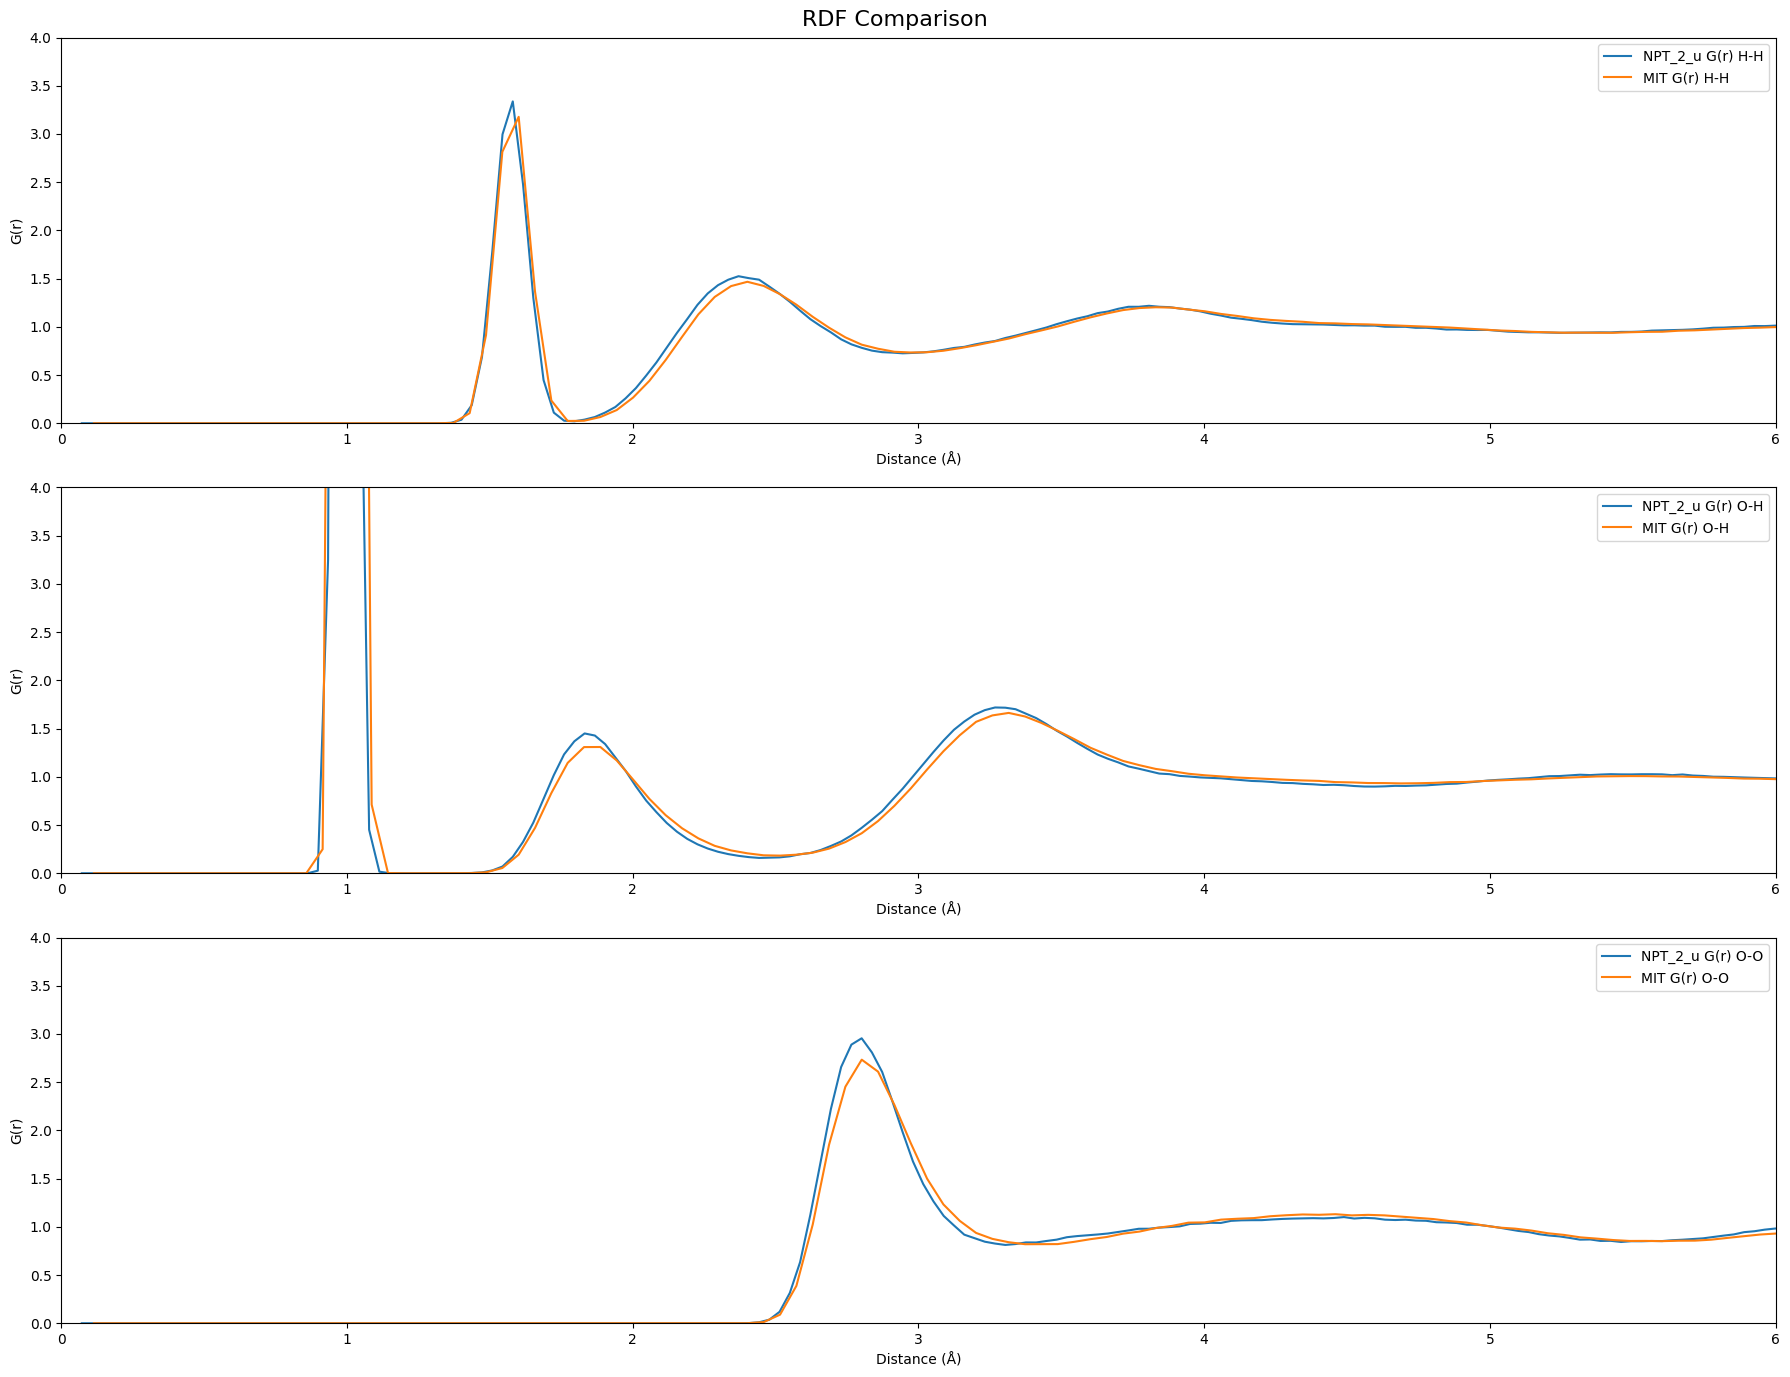

In [119]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, figsize=(18, 14))
fig.suptitle(f"RDF Comparison", fontsize=16)
for name, rdf_set in rdf_results.items():
    

    # H-H
    ax[0].plot(rdf_set["HH"].results.edges[2:], rdf_set["HH"].results.rdf[1:], label=f"{name} G(r) H-H")
    #ax[0].plot(HH["r"], HH["G(r)"], linestyle="-", label="Experimental G(r) H-H", color="black")

    # O-H
    ax[1].plot(rdf_set["OH"].results.edges[2:], rdf_set["OH"].results.rdf[1:], label=f"{name} G(r) O-H")
    #ax[1].plot(OH["r"], OH["G(r)"], linestyle="-", label="Experimental G(r) O-H", color="black")

    # O-O
    ax[2].plot(rdf_set["OO"].results.edges[2:], rdf_set["OO"].results.rdf[1:], label=f"{name} G(r) O-O")
    #ax[2].plot(OO["r"], OO["G(r)"], linestyle="-", label="Experimental G(r) O-O", color="black")

for a in ax:
        a.set_xlabel("Distance (Å)")
        a.set_ylabel("G(r)")
        a.set_ylim(0, 4)
        a.set_xlim(0, 6)
        a.legend()

fig.tight_layout()
fig.savefig(f"/home/forina/Documents/MIT/MIT_Results/Rdf/Plots/RDF_Comparison.png")
plt.show()

In [120]:
for name, rdf_set in rdf_results.items():
    # 1) make a directory for this universe if it doesn't exists yet
    if not os.path.exists("../Rdf/Data/" + name):
        os.makedirs("../Rdf/Data/" + name, exist_ok=True)

    # 2) for each pair, save a two‐column CSV of r vs G(r)
    for pair in ("OO", "HH", "OH"):
        r = rdf_set[pair].results.edges[2:]
        g = rdf_set[pair].results.rdf[1:]
        data = np.vstack((r, g)).T

        # e.g. "NPT_2_u/OO.csv", "MIT/HH.csv", ...
        fname = os.path.join("../Rdf/Data/" + name, f"{name}_{pair}.csv")
        np.savetxt(
            fname,
            data,
            delimiter=",",
            header="r,G(r)",
            comments=""
        )
        print(f"Written {fname}")

Written ../Rdf/Data/NPT_2_u/NPT_2_u_OO.csv
Written ../Rdf/Data/NPT_2_u/NPT_2_u_HH.csv
Written ../Rdf/Data/NPT_2_u/NPT_2_u_OH.csv
Written ../Rdf/Data/MIT/MIT_OO.csv
Written ../Rdf/Data/MIT/MIT_HH.csv
Written ../Rdf/Data/MIT/MIT_OH.csv


In [121]:
# Define the folder that contains the CSV files
base_dir = "/home/forina/Documents/MIT/MIT_Results/Rdf/Data"
# dizionario vuoto dove memorizzare i DataFrame
import os
import pandas as pd

  # cartella che contiene le sottocartelle dei vari universi

# --- 1) APPROCCIO AUTOMATICO: elenco tutte le sottocartelle ---
all_folders = [
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
]

# --- 2) APPROCCIO MANUALE: definisco io la lista delle cartelle ---
# all_folders = ["MIT", "NPT_2_u", "AltraCartella"]


# Ora leggo tutti i CSV in un dizionario strutturato
pandas_rdf_dfs = {}

for universe in all_folders:
    folder_path = os.path.join(base_dir, universe)
    pandas_rdf_dfs[universe] = {}

    for pair in ("OO", "HH", "OH"):
        csv_path = os.path.join(folder_path, f"{universe}_{pair}.csv")
        if os.path.isfile(csv_path):
            df = pd.read_csv(csv_path)
            pandas_rdf_dfs[universe][pair] = df
            print(f"✔ Caricato {csv_path} → shape {df.shape}")
        else:
            print(f"⚠ File non trovato: {csv_path}")

# Esempio di accesso:
# df_OO = rdf_dfs["MIT"]["OO"]
# r_values = df_OO["r"]
# g_values = df_OO["G(r)"]



✔ Caricato /home/forina/Documents/MIT/MIT_Results/Rdf/Data/NPT_2_u/NPT_2_u_OO.csv → shape (199, 2)
✔ Caricato /home/forina/Documents/MIT/MIT_Results/Rdf/Data/NPT_2_u/NPT_2_u_HH.csv → shape (199, 2)
✔ Caricato /home/forina/Documents/MIT/MIT_Results/Rdf/Data/NPT_2_u/NPT_2_u_OH.csv → shape (199, 2)
✔ Caricato /home/forina/Documents/MIT/MIT_Results/Rdf/Data/MIT/MIT_OO.csv → shape (199, 2)
✔ Caricato /home/forina/Documents/MIT/MIT_Results/Rdf/Data/MIT/MIT_HH.csv → shape (199, 2)
✔ Caricato /home/forina/Documents/MIT/MIT_Results/Rdf/Data/MIT/MIT_OH.csv → shape (199, 2)


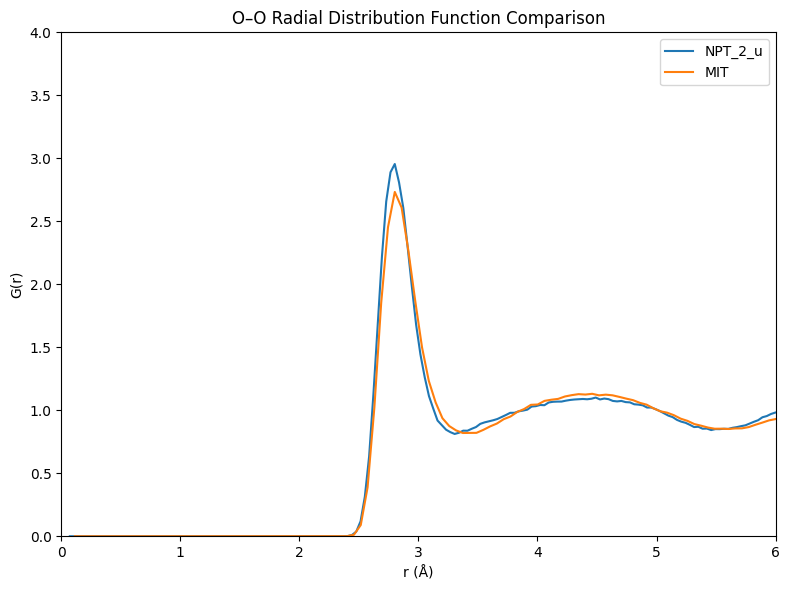

In [122]:
import matplotlib.pyplot as plt

# Plot O–O RDF for all universes
plt.figure(figsize=(8, 6))
for universe, rdf_dict in pandas_rdf_dfs.items():
    df_OO = rdf_dict.get("OO")
    if df_OO is not None:
        plt.plot(df_OO["r"], df_OO["G(r)"], label=universe)

plt.xlabel("r (Å)")
plt.ylabel("G(r)")
plt.title("O–O Radial Distribution Function Comparison")
plt.legend(title="Universe")
plt.ylim(0, 4)
plt.xlim(0, 6)
plt.legend()
plt.tight_layout()
plt.show()

# Diffusion Coefficient for water

In [227]:
!pip install tidynamics

In [228]:
import MDAnalysis.analysis.msd as msd
MSD = msd.EinsteinMSD(NPT_2_u, select='all', msd_type='xyz', fft=False)
MSD.run(step = 10)

/home/forina/Documents/MIT/MIT_Results/mdaenv/lib/python3.12/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
100%|██████████| 3962/3962 [00:50<00:00, 78.94it/s] 


In [229]:
msd =  MSD.results.timeseries

In [82]:
print(msd)

[  0.           2.41713993   4.09886712   5.6914102    7.27911388
   8.81606584  10.33307826  11.78606587  13.25114761  14.73670748
  16.2119692   17.67686393  19.12978856  20.57134339  21.98243227
  23.38177897  24.77798521  26.22234382  27.63404411  29.03061484
  30.46383982  31.89853561  33.33731407  34.75236242  36.18868305
  37.63398141  39.0626833   40.52463432  41.92929344  43.3669902
  44.75252004  46.13647433  47.54791586  48.95255281  50.35018305
  51.73244908  53.15196429  54.55670161  55.95094156  57.33662078
  58.75104733  60.161598    61.53133552  62.91308527  64.33774668
  65.74390203  67.13194785  68.53019438  69.95785851  71.3881363
  72.81361726  74.22866222  75.6637287   77.11329594  78.54792333
  79.97522849  81.43041393  82.86800484  84.28708941  85.75329069
  87.21877479  88.67337987  90.15541969  91.61623184  93.11146871
  94.56324788  95.99009989  97.44212552  98.87268282 100.28293892
 101.72832496 103.1520809  104.62088945 106.07132211 107.51466447
 108.9817208

792.6


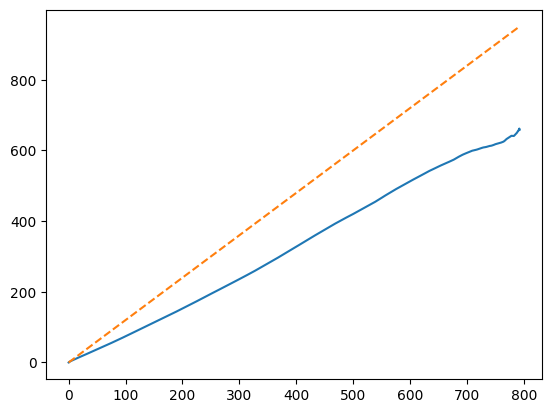

In [230]:
import matplotlib.pyplot as plt
nframes = MSD.n_frames
print(nframes * 0.2)
timestep = 0.2 # this needs to be the actual time between frames
lagtimes = np.arange(nframes)*timestep # make the lag-time axis
fig = plt.figure()
ax = plt.axes()
# plot the actual MSD
ax.plot(lagtimes, msd, ls="-", label=r'3D random walk')
exact = lagtimes*6 * 0.2
# plot the exact result
ax.plot(lagtimes, exact, ls="--", label=r'$y=2 D\tau$')
plt.show()

In [219]:
# Find the maximum and minimum lagtimes for the MSD 
print(lagtimes.max())
print(lagtimes.min())

792.4000000000001
0.0


In [234]:
from scipy.stats import linregress
start_time = 400
start_index = int(start_time/timestep)
end_time = 700
end_index = int(end_time/timestep)
linear_model = linregress(lagtimes[start_index:end_index],
                                              msd[start_index:end_index])
slope = linear_model.slope
error = linear_model.stderr
# dim_fac is 3 as we computed a 3D msd with 'xyz'
D = slope * 1/(2*MSD.dim_fac)
print(f"The Diffusion Coefficient is equal to: {D} A^2/ps")

The Diffusion Coefficient is equal to: 0.14878224001941123 A^2/ps


# Volume in the NPT Simulation
In this section is going to be evaluated the equilibration volume for the system

In [239]:
time = []
volume = []

for i, ts in enumerate(universes["NPT_2_u"].trajectory[30000:]):
    # Append the time and volume to the lists
    time.append(i * 0.2)  # Assuming a timestep of 0.2 ps
    volume.append(ts.volume)  # Convert from Å³ to cm³

volume = np.array(volume)
time = np.array(time)

/home/forina/Documents/MIT/MIT_Results/mdaenv/lib/python3.12/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


Just a reminder that the following plot has been obtained after at least 1 ns of equilibration

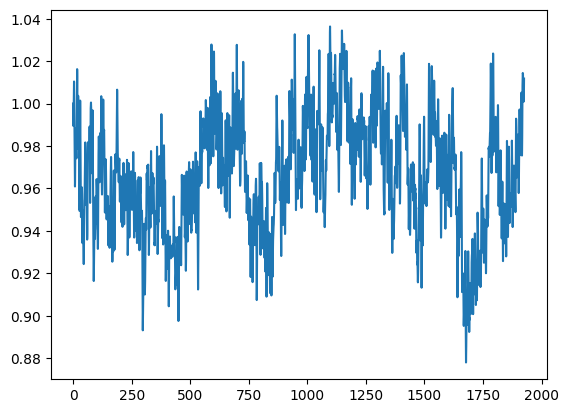

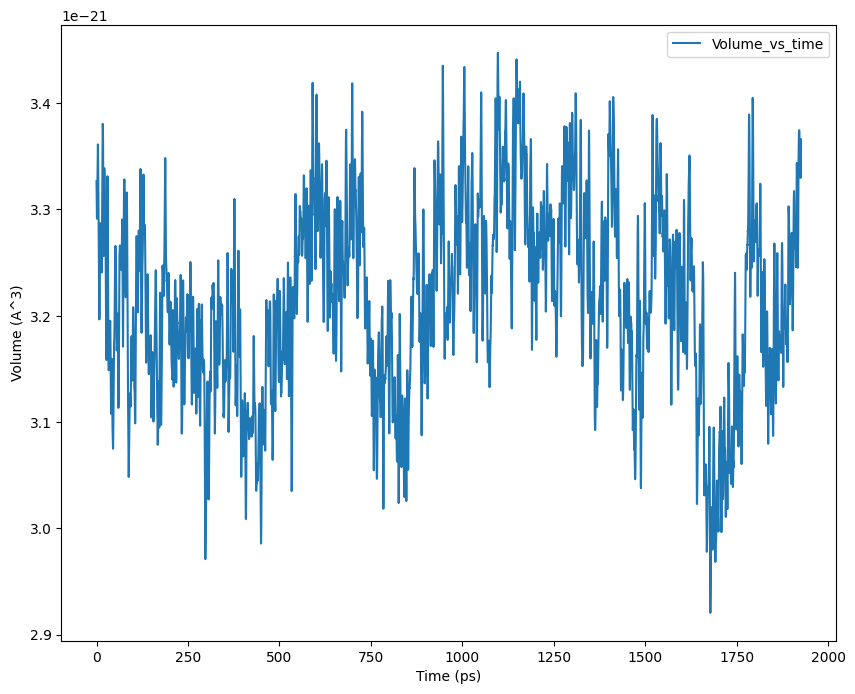

In [ ]:
plt.plot(time, volume/volume[0])
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.plot(time, volume, label="Volume_vs_time")
ax.set_xlabel("Time (ps)")
ax.set_ylabel("Volume (A^3)")
ax.legend()
fig.savefig("../Rdf/Plots/V_vs_time.png")
plt.show()